# Predictive Analytics : Constructing the Datasets

**Author: Onur Koc**



## Preamble

In [1]:
# importing required modules 
import numpy as np
import pandas as pd
import matplotlib as mpl
import h3
import h3pandas
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import holidays
import io
import urllib.request

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

%matplotlib inline

## Spatio-Temporal Data Aggregation

**Aggregating the taxi trip data by spatial units and temporal buckets:**

Spatial unit sizes:

+ census tract
+ hexagon with resolution 6, 7 & 8

Temporal bucket sizes:

+ 1 Hourly, 2 Hourly, 6 Houly & Daily

**Reading preprocessed data**

In [2]:
file_path = "./data/"
# reading preprocessed taxi trip data
taxi = pd.read_csv(f"{file_path}taxi_processed_pred.csv",
                        dtype={"trip_id":"str",
                               "taxi_id":"str",
                               "trip_seconds":"float",
                               "trip_miles":"float",
                               "trip_total":"float",
                               "company":"category",
                               "payment_type":"category",
                               "start_temp":"float",
                               "start_precip":"bool",
                               "start_windspeed":"float",
                               "end_temp":"float",
                               "end_precip":"bool",
                               "end_windspeed":"float",
                               "h3_6_pickup":"str",
                               "h3_6_dropoff":"str",
                               "h3_7_pickup":"str",
                               "h3_7_dropoff":"str",
                               "h3_8_pickup":"str",
                               "h3_8_dropoff":"str"
                              },
                        parse_dates=["trip_start_timestamp","trip_end_timestamp"])

In [3]:
# reading weather data
weather_df = pd.read_csv(f"{file_path}chicago_weather_2021.csv", parse_dates=["date"])

In [4]:
# reading geographical data
community_centroids = pd.read_csv(f"{file_path}chicago_community_centroid.csv")
community_areas_geojson = gpd.read_file(f"{file_path}chicago_community_areas.geojson")
census_tracts_geojson = gpd.read_file(f"{file_path}chicago_census_tracts.geojson")

# see "1_data_preperation" under "Add geographical information"
geographic_data = community_centroids.merge(right=census_tracts_geojson.astype({"geoid10" : "float"})[["geoid10", "geometry"]], how="left", left_on="Census_tract", right_on="geoid10")
geographic_data.update(community_centroids.merge(right=community_areas_geojson.astype({"area_num_1" : "float"}), how="left", left_on="Community_Area", right_on="area_num_1"),)
geographic_data.drop("geoid10", axis=1, inplace=True)

geographic_data["h3_6"] = geographic_data.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=6), axis=1)
geographic_data["h3_7"] = geographic_data.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=7), axis=1)
geographic_data["h3_8"] = geographic_data.apply(lambda x: h3.geo_to_h3(x.Latitude, x.Longitude, resolution=8), axis=1)

**Defining functions to create a spatio temporal aggregation**

In [5]:
def include_weather_features(df, freq):
    ## Include the weather features    
    # Rename columns
    columns_to_rename = {'date': 'datetime',
                         'temp_2m': 'temp', 
                         'windspeed_50m': 'windspeed'}
    weather_df.rename(columns=columns_to_rename, inplace=True)
    
    # Aggregate the Weather data to match the frequency
    agg_weather_df = weather_df.groupby(pd.Grouper(key='datetime', freq=freq)).mean()
    
    # Round the 'precip' column to the nearest integer
    agg_weather_df['precip'] = agg_weather_df['precip'].round().astype(int)

    # Merge the weather columns from 'weather_df' based on the 'datetime' index
    merged_df = df.merge(agg_weather_df[['temp','precip','windspeed']], left_index=True, right_index=True, how='left')

    # change dtypes
    dtype_mapping = {'precip': 'int'}
    merged_df = merged_df.astype(dtype_mapping)
    return merged_df

In [6]:
def fill_missing_datetime(df, geo_column_name, freq):
    # Create a new DatetimeIndex with a specific frequency for the entire year 2021
    full_date_range = pd.date_range(start='2021-01-01 00:00:00', end='2021-12-31 23:00:00', freq=freq)

    # Create a MultiIndex with all combinations of hexagon IDs and the full_date_range
    hexagon_ids = df[geo_column_name].unique()
    multi_index = pd.MultiIndex.from_product([hexagon_ids, full_date_range], names=[geo_column_name, 'datetime'])

    # Reindex the DataFrame with the new MultiIndex
    df = df.set_index([geo_column_name, df.index])
    df = df.reindex(multi_index)
    
    # Fill missing rows
    columns_to_fill_with_zero = ['trip_demand', 
                                 'mean_trip_seconds', 
                                 'mean_trip_miles', 
                                 'mean_trip_cost']
    df[columns_to_fill_with_zero] = df[columns_to_fill_with_zero].fillna(0)
    
    # change dtypes
    dtype_mapping = {'trip_demand': 'int'}
    df = df.astype(dtype_mapping)
    return hexagon_ids, df

In [7]:
def spatio_temporal_aggregation(geo_column_name_taxi_pickup, freq):
    # Drop unnecessary columns
    drop_columns = ["taxi_id", "trip_end_timestamp", "company", "payment_type"]
    taxi_dropped = taxi.drop(drop_columns, axis=1)

    # Define aggregation functions
    aggregation = {
        "trip_id": "count",
        "trip_seconds": "mean",
        "trip_miles": "mean",
        "trip_total": "mean"}

    # Group by pickup and dropoff geographical location, as well as trip start time
    taxi_by_geotemp = taxi_dropped.groupby([pd.Grouper(key='trip_start_timestamp', freq=freq), pd.Grouper(geo_column_name_taxi_pickup)]).agg(aggregation)
    
    taxi_by_geotemp.rename(columns={"trip_seconds": "mean_trip_seconds",
                                    "trip_id": "trip_demand",
                                    "trip_miles": "mean_trip_miles",
                                    "trip_total": "mean_trip_cost"}, inplace=True)
    
    taxi_by_geotemp = taxi_by_geotemp.reset_index()
    
    # Drop row when either timestamp or geographical location is empty, as that data is not useful for geotemporal analysis
    taxi_by_geotemp.dropna(subset=[geo_column_name_taxi_pickup, "trip_start_timestamp"], inplace=True)
    
    # Fill NaN values with 0
    taxi_by_geotemp['trip_demand'].fillna(0, inplace=True)
    
    taxi_by_geotemp.set_index('trip_start_timestamp', inplace=True)
    return taxi_by_geotemp

**Create Spatio-Temporal Aggregations**

**Temporal Aggregations for Census Tracts**

In [82]:
# Aggregation by 1 Hour
taxi_by_census_tract_1H = spatio_temporal_aggregation("pickup_census_tract", "1H")
census_ids_1H, taxi_by_census_tract_1H = fill_missing_datetime(taxi_by_census_tract_1H, "pickup_census_tract", "1H")
taxi_by_census_tract_1H = include_weather_features(taxi_by_census_tract_1H, "1H")


# Aggregation by 2 Hours
taxi_by_census_tract_2H = spatio_temporal_aggregation("pickup_census_tract", "2H")
census_ids_2H, taxi_by_census_tract_2H = fill_missing_datetime(taxi_by_census_tract_2H, "pickup_census_tract", "2H")
taxi_by_census_tract_2H = include_weather_features(taxi_by_census_tract_2H, "2H")


# Aggregation by 6 Hours
taxi_by_census_tract_6H = spatio_temporal_aggregation("pickup_census_tract", "6H")
census_ids_6H, taxi_by_census_tract_6H = fill_missing_datetime(taxi_by_census_tract_6H, "pickup_census_tract", "6H")
taxi_by_census_tract_6H = include_weather_features(taxi_by_census_tract_6H, "6H")


# Aggregation by 1 Day
taxi_by_census_tract_24H = spatio_temporal_aggregation("pickup_census_tract", "D")
census_ids_24H, taxi_by_census_tract_24H = fill_missing_datetime(taxi_by_census_tract_24H, "pickup_census_tract", "D")
taxi_by_census_tract_24H = include_weather_features(taxi_by_census_tract_24H, "D")

**Temporal Aggregations for Hexagons with Resolution 6**

In [83]:
# Aggregation by 1 Hour
taxi_by_h3_6_1H = spatio_temporal_aggregation("h3_6_pickup", "1H")
hexagon_ids_h3_6_1H, taxi_by_h3_6_1H = fill_missing_datetime(taxi_by_h3_6_1H, "h3_6_pickup", "1H")
taxi_by_h3_6_1H = include_weather_features(taxi_by_h3_6_1H, "1H")

# Aggregation by 2 Hours
taxi_by_h3_6_2H = spatio_temporal_aggregation("h3_6_pickup", "2H")
hexagon_ids_h3_6_2H, taxi_by_h3_6_2H = fill_missing_datetime(taxi_by_h3_6_2H, "h3_6_pickup", "2H")
taxi_by_h3_6_2H = include_weather_features(taxi_by_h3_6_2H, "2H")

# Aggregation by 6 Hours
taxi_by_h3_6_6H = spatio_temporal_aggregation("h3_6_pickup", "6H")
hexagon_ids_h3_6_6H, taxi_by_h3_6_6H = fill_missing_datetime(taxi_by_h3_6_6H, "h3_6_pickup", "6H")
taxi_by_h3_6_6H = include_weather_features(taxi_by_h3_6_6H, "6H")

# Aggregation by 1 Day
taxi_by_h3_6_24H = spatio_temporal_aggregation("h3_6_pickup", "D")
hexagon_ids_h3_6_24H, taxi_by_h3_6_24H = fill_missing_datetime(taxi_by_h3_6_24H, "h3_6_pickup", "D")
taxi_by_h3_6_24H = include_weather_features(taxi_by_h3_6_24H, "D")

**Temporal Aggregations for Hexagons with Resolution 7**

In [84]:
# Aggregation by 1 Hour
taxi_by_h3_7_1H = spatio_temporal_aggregation("h3_7_pickup", "1H")
hexagon_ids_h3_7_1H, taxi_by_h3_7_1H = fill_missing_datetime(taxi_by_h3_7_1H, "h3_7_pickup", "1H")
taxi_by_h3_7_1H = include_weather_features(taxi_by_h3_7_1H, "1H")

# Aggregation by 2 Hours
taxi_by_h3_7_2H = spatio_temporal_aggregation("h3_7_pickup", "2H")
hexagon_ids_h3_7_2H, taxi_by_h3_7_2H = fill_missing_datetime(taxi_by_h3_7_2H, "h3_7_pickup", "2H")
taxi_by_h3_7_2H = include_weather_features(taxi_by_h3_7_2H, "2H")

# Aggregation by 6 Hours
taxi_by_h3_7_6H = spatio_temporal_aggregation("h3_7_pickup", "6H")
hexagon_ids_h3_7_6H, taxi_by_h3_7_6H = fill_missing_datetime(taxi_by_h3_7_6H, "h3_7_pickup", "6H")
taxi_by_h3_7_6H = include_weather_features(taxi_by_h3_7_6H, "6H")

# Aggregation by 1 Day
taxi_by_h3_7_24H = spatio_temporal_aggregation("h3_7_pickup", "D")
hexagon_ids_h3_7_24H, taxi_by_h3_7_24H = fill_missing_datetime(taxi_by_h3_7_24H, "h3_7_pickup", "D")
taxi_by_h3_7_24H = include_weather_features(taxi_by_h3_7_24H, "D")

**Temporal Aggregations for Hexagons with Resolution 8**

In [75]:
# Aggregation by 1 Hour
taxi_by_h3_8_1H = spatio_temporal_aggregation("h3_8_pickup", "1H")
hexagon_ids_h3_8_1H, taxi_by_h3_8_1H = fill_missing_datetime(taxi_by_h3_8_1H, "h3_8_pickup", "1H")
taxi_by_h3_8_1H = include_weather_features(taxi_by_h3_8_1H, "1H")

# Aggregation by 2 Hours
taxi_by_h3_8_2H = spatio_temporal_aggregation("h3_8_pickup", "2H")
hexagon_ids_h3_8_2H, taxi_by_h3_8_2H = fill_missing_datetime(taxi_by_h3_8_2H, "h3_8_pickup", "2H")
taxi_by_h3_8_2H = include_weather_features(taxi_by_h3_8_2H, "2H")

# Aggregation by 6 Hours
taxi_by_h3_8_6H = spatio_temporal_aggregation("h3_8_pickup", "6H")
hexagon_ids_h3_8_6H, taxi_by_h3_8_6H = fill_missing_datetime(taxi_by_h3_8_6H, "h3_8_pickup", "6H")
taxi_by_h3_8_6H = include_weather_features(taxi_by_h3_8_6H, "6H")

# Aggregation by 1 Day
taxi_by_h3_8_24H = spatio_temporal_aggregation("h3_8_pickup", "D")
hexagon_ids_h3_8_24H, taxi_by_h3_8_24H = fill_missing_datetime(taxi_by_h3_8_24H, "h3_8_pickup", "D")
taxi_by_h3_8_24H = include_weather_features(taxi_by_h3_8_24H, "D")

## Feature Engineering

**Goal : Developing a rich set of features that we expect to be correlated with the target (taxi trip demant).**

**Summary of Multiindex Datasets:**

<ins>Spatio-Temporal Aggregations for Census Tracts:</ins>
+ taxi_by_census_tract_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_census_tract_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_census_tract_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_census_tract_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 6:</ins>
+ taxi_by_h3_6_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_h3_6_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_h3_6_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_h3_6_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 7:</ins>
+ taxi_by_h3_7_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_h3_7_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_h3_7_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_h3_7_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 8:</ins> **-> not using this resolution, since its almost the same as census tract level**
+ taxi_by_h3_8_1H
+ taxi_by_h3_8_2H
+ taxi_by_h3_8_6H
+ taxi_by_h3_8_24H


**Summary of Features**

<ins>Target Variable:</ins> 
+ trip_demand : number of starting trips for each time bucket of year 2021

<ins>Features:</ins>

+ precip : binary feature that indicates whether the current time-bucket has precipitation or not.
+ windspeed_z : normalized average windspeed
+ temp_z : normalized average temperature
+ temp_z_ma_7d : moving average of the normalized temperature over 7 days
+ temp_z_std_7d : moving standard deviation of the normalized temperature over 7 days
+ weekday_sin : sine tranformed weekday
+ weekday_cos : cosine transformed weekday
+ is_weekend : binary feature to indicate whether the current time-bucket falls on a weekend or not
+ is_holiday : binary feature to indicate whether the current time-bucket falls on a holiday or not
+ 12 month dummies : month_January to month_December

In [85]:
taxi_by_h3_6_1H

trip_demand  mean_trip_seconds  \
h3_6_pickup     datetime                                              
862664527ffffff 2021-01-01 00:00:00            4             1215.0   
                2021-01-01 01:00:00            1             1140.0   
                2021-01-01 02:00:00            0                0.0   
                2021-01-01 03:00:00            0                0.0   
                2021-01-01 04:00:00            0                0.0   
...                                          ...                ...   
8626641b7ffffff 2021-12-31 19:00:00            2             1551.5   
                2021-12-31 20:00:00            0                0.0   
                2021-12-31 21:00:00            0                0.0   
                2021-12-31 22:00:00            1             1440.0   
                2021-12-31 23:00:00            0                0.0   

                                     mean_trip_miles  mean_trip_cost  temp  \
h3_6_pickup     datetime                                                     
862664527ffffff 2021-01-01 00:00:00            8.675          43.895 -1.33   
                2021-01-01 01:00:00           12.500          35.500 -1.28   
                2021-01-01 02:00:00            0.000           0.000 -1.31   
                2021-01-01 03:00:00            0.000           0.000 -1.16   
                2021-01-01 04:00:00            0.000           0.000 -0.98   
...                                              ...             ...   ...   
8626641b7ffffff 2021-12-31 19:00:00            4.860          31.375  5.24   
                2021-12-31 20:00:00            0.000           0.000  5.12   
                2021-12-31 21:00:00            0.000           0.000  4.69   
                2021-12-31 22:00:00            0.600          28.000  4.20   
                2021-12-31 23:00:00            0.000           0.000  3.80   

                                     precip  windspeed  
h3_6_pickup     datetime                                
862664527ffffff 2021-01-01 00:00:00       0       6.35  
                2021-01-01 01:00:00       0       7.12  
                2021-01-01 02:00:00       0       7.48  
                2021-01-01 03:00:00       0       7.30  
                2021-01-01 04:00:00       0       7.33  
...                                     ...        ...  
8626641b7ffffff 2021-12-31 19:00:00       0       3.23  
                2021-12-31 20:00:00       0       7.38  
                2021-12-31 21:00:00       0       9.70  
                2021-12-31 22:00:00       0      10.74  
                2021-12-31 23:00:00       0      10.83  

[219000 rows x 7 columns]

In [86]:
taxi_by_h3_6_1H.loc["862664527ffffff"].iloc[:,[2,3]]

,mean_trip_miles,mean_trip_cost
datetime,,
2021-01-01 00:00:00,8.675000,43.895000
2021-01-01 01:00:00,12.500000,35.500000
2021-01-01 02:00:00,0.000000,0.000000
2021-01-01 03:00:00,0.000000,0.000000
2021-01-01 04:00:00,0.000000,0.000000
...,...,...
2021-12-31 19:00:00,8.736364,42.979545
2021-12-31 20:00:00,9.324667,36.284667
2021-12-31 21:00:00,9.769231,45.696154


### Deriving new Features


**Excluding features which are directly derived from the target variable**

'mean_trip_seconds', 'mean_trip_miles' & 'mean_trip_cost' are directly derived from the target variable trip_demand. Therefore we drop them.

In [87]:
# Dropping the columns 'mean_trip_seconds', 'mean_trip_miles' & 'mean_trip_cost'
taxi_by_h3_6_1H = taxi_by_h3_6_1H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_h3_6_2H = taxi_by_h3_6_2H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_h3_6_6H = taxi_by_h3_6_6H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_h3_6_24H = taxi_by_h3_6_24H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])

taxi_by_h3_7_1H = taxi_by_h3_7_1H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_h3_7_2H = taxi_by_h3_7_2H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_h3_7_6H = taxi_by_h3_7_6H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_h3_7_24H = taxi_by_h3_7_24H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])

taxi_by_census_tract_1H = taxi_by_census_tract_1H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_census_tract_2H = taxi_by_census_tract_2H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_census_tract_6H = taxi_by_census_tract_6H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])
taxi_by_census_tract_24H = taxi_by_census_tract_24H.drop(columns = ['mean_trip_seconds','mean_trip_miles','mean_trip_cost'])

In [88]:
taxi_by_h3_6_1H.head()

trip_demand  temp  precip  windspeed
h3_6_pickup     datetime                                                 
862664527ffffff 2021-01-01 00:00:00            4 -1.33       0       6.35
                2021-01-01 01:00:00            1 -1.28       0       7.12
                2021-01-01 02:00:00            0 -1.31       0       7.48
                2021-01-01 03:00:00            0 -1.16       0       7.30
                2021-01-01 04:00:00            0 -0.98       0       7.33

**Normalizing features**

Support Vector Machines (SVMs) are sensitive to the scale of input features.
Normalizing helps to standardize the scale of the features and makes it easier to compare the relative importance of the different features. This allows the model to weigh the features more evenly and not be influenced by the scale of the features.
It can also improve the convergence and stability of the optimization process and lead to more robust predicitons.

Normalizing the following columns: 'temp' , 'windspeed' for all datasets

In [89]:
taxi_by_h3_6_1H.loc["862664527ffffff"].iloc[:,[1,3]].head(1)

,temp,windspeed
datetime,,
2021-01-01,-1.33,6.35


In [90]:
# Initialize the scaler
scaler = StandardScaler()

# Normalize the columns for each area id
for area_id in hexagon_ids_h3_6_1H:
    taxi_by_h3_6_1H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_6_1H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_h3_6_2H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_6_2H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_h3_6_6H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_6_6H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_h3_6_24H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_6_24H.loc[area_id, ['temp', 'windspeed']])
    
for area_id in hexagon_ids_h3_7_1H:
    taxi_by_h3_7_1H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_7_1H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_h3_7_2H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_7_2H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_h3_7_6H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_7_6H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_h3_7_24H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_h3_7_24H.loc[area_id, ['temp', 'windspeed']])

for area_id in census_ids_1H:
    taxi_by_census_tract_1H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_census_tract_1H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_census_tract_2H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_census_tract_2H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_census_tract_6H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_census_tract_6H.loc[area_id, ['temp', 'windspeed']])
    taxi_by_census_tract_24H.loc[area_id, ['temp', 'windspeed']] = scaler.fit_transform(taxi_by_census_tract_24H.loc[area_id, ['temp', 'windspeed']])


# Rename the columns
taxi_by_h3_6_1H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_h3_6_2H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_h3_6_6H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_h3_6_24H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)

taxi_by_h3_7_1H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_h3_7_2H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_h3_7_6H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_h3_7_24H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)

taxi_by_census_tract_1H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_census_tract_2H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_census_tract_6H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)
taxi_by_census_tract_24H.rename(columns={'temp' : 'temp_z', 'windspeed' : 'windspeed_z'}, inplace=True)

In [93]:
taxi_by_h3_6_1H.head()

trip_demand    temp_z  precip  \
h3_6_pickup     datetime                                             
862664527ffffff 2021-01-01 00:00:00            4 -1.248857       0   
                2021-01-01 01:00:00            1 -1.243863       0   
                2021-01-01 02:00:00            0 -1.246859       0   
                2021-01-01 03:00:00            0 -1.231879       0   
                2021-01-01 04:00:00            0 -1.213902       0   

                                     windspeed_z  
h3_6_pickup     datetime                          
862664527ffffff 2021-01-01 00:00:00    -0.217303  
                2021-01-01 01:00:00     0.008083  
                2021-01-01 02:00:00     0.113459  
                2021-01-01 03:00:00     0.060771  
                2021-01-01 04:00:00     0.069552

**Deriving the binary feature 'is_holiday' using the 'python-holidays' library and the holiday calendar for chicago IL:**

Creating a binary feature to indicate whether the current hour falls on a holiday or not. Holidays may have an impact on the demand.

In [94]:
# Create a list of holidays in Illinois (Chicago) for the year 2021
chicago_holidays = holidays.UnitedStates(state='IL', years=[2021])

# Adding the new holiday indicator feature for every dataset
taxi_by_h3_6_1H['is_holiday'] = taxi_by_h3_6_1H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_h3_6_2H['is_holiday'] = taxi_by_h3_6_2H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_h3_6_6H['is_holiday'] = taxi_by_h3_6_6H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_h3_6_24H['is_holiday'] = taxi_by_h3_6_24H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)

taxi_by_h3_7_1H['is_holiday'] = taxi_by_h3_7_1H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_h3_7_2H['is_holiday'] = taxi_by_h3_7_2H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_h3_7_6H['is_holiday'] = taxi_by_h3_7_6H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_h3_7_24H['is_holiday'] = taxi_by_h3_7_24H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)

taxi_by_census_tract_1H['is_holiday'] = taxi_by_census_tract_1H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_census_tract_2H['is_holiday'] = taxi_by_census_tract_2H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_census_tract_6H['is_holiday'] = taxi_by_census_tract_6H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)
taxi_by_census_tract_24H['is_holiday'] = taxi_by_census_tract_24H.index.get_level_values('datetime').map(lambda x: 1 if x in chicago_holidays else 0)

In [95]:
taxi_by_h3_6_1H.loc["8626641b7ffffff"].head()

,trip_demand,temp_z,precip,windspeed_z,is_holiday
datetime,,,,,
2021-01-01 00:00:00,0,-1.248857,0,-0.217303,1
2021-01-01 01:00:00,0,-1.243863,0,0.008083,1
2021-01-01 02:00:00,0,-1.246859,0,0.113459,1
2021-01-01 03:00:00,0,-1.231879,0,0.060771,1
2021-01-01 04:00:00,0,-1.213902,0,0.069552,1


**Deriving time-based features 'hour', 'weekday', 'is_weekend', 'month' & 'season'**

In [20]:
# hour is not comparable, when we are using different time buckets up to daily aggregations, therefore we dont use it
"""
# Deriving the new column 'hour' for every Dataset
taxi_by_h3_6_1H['hour'] = taxi_by_h3_6_1H.index.get_level_values('datetime').hour
taxi_by_h3_6_2H['hour'] = taxi_by_h3_6_2H.index.get_level_values('datetime').hour
taxi_by_h3_6_6H['hour'] = taxi_by_h3_6_6H.index.get_level_values('datetime').hour
taxi_by_h3_6_24H['hour'] = taxi_by_h3_6_24H.index.get_level_values('datetime').hour

taxi_by_h3_7_1H['hour'] = taxi_by_h3_7_1H.index.get_level_values('datetime').hour
taxi_by_h3_7_2H['hour'] = taxi_by_h3_7_2H.index.get_level_values('datetime').hour
taxi_by_h3_7_6H['hour'] = taxi_by_h3_7_6H.index.get_level_values('datetime').hour
taxi_by_h3_7_24H['hour'] = taxi_by_h3_7_24H.index.get_level_values('datetime').hour

taxi_by_census_tract_1H['hour'] = taxi_by_census_tract_1H.index.get_level_values('datetime').hour
taxi_by_census_tract_2H['hour'] = taxi_by_census_tract_2H.index.get_level_values('datetime').hour
taxi_by_census_tract_6H['hour'] = taxi_by_census_tract_6H.index.get_level_values('datetime').hour
taxi_by_census_tract_24H['hour'] = taxi_by_census_tract_24H.index.get_level_values('datetime').hour
"""

"\n# Deriving the new column 'hour' for every Dataset\ntaxi_by_h3_6_1H['hour'] = taxi_by_h3_6_1H.index.get_level_values('datetime').hour\ntaxi_by_h3_6_2H['hour'] = taxi_by_h3_6_2H.index.get_level_values('datetime').hour\ntaxi_by_h3_6_6H['hour'] = taxi_by_h3_6_6H.index.get_level_values('datetime').hour\ntaxi_by_h3_6_24H['hour'] = taxi_by_h3_6_24H.index.get_level_values('datetime').hour\n\ntaxi_by_h3_7_1H['hour'] = taxi_by_h3_7_1H.index.get_level_values('datetime').hour\ntaxi_by_h3_7_2H['hour'] = taxi_by_h3_7_2H.index.get_level_values('datetime').hour\ntaxi_by_h3_7_6H['hour'] = taxi_by_h3_7_6H.index.get_level_values('datetime').hour\ntaxi_by_h3_7_24H['hour'] = taxi_by_h3_7_24H.index.get_level_values('datetime').hour\n\ntaxi_by_census_tract_1H['hour'] = taxi_by_census_tract_1H.index.get_level_values('datetime').hour\ntaxi_by_census_tract_2H['hour'] = taxi_by_census_tract_2H.index.get_level_values('datetime').hour\ntaxi_by_census_tract_6H['hour'] = taxi_by_census_tract_6H.index.get_level_v

In [96]:
# Deriving the new column 'weekday' for every Dataset
taxi_by_h3_6_1H['weekday'] = taxi_by_h3_6_1H.index.get_level_values('datetime').weekday
taxi_by_h3_6_2H['weekday'] = taxi_by_h3_6_2H.index.get_level_values('datetime').weekday
taxi_by_h3_6_6H['weekday'] = taxi_by_h3_6_6H.index.get_level_values('datetime').weekday
taxi_by_h3_6_24H['weekday'] = taxi_by_h3_6_24H.index.get_level_values('datetime').weekday

taxi_by_h3_7_1H['weekday'] = taxi_by_h3_7_1H.index.get_level_values('datetime').weekday
taxi_by_h3_7_2H['weekday'] = taxi_by_h3_7_2H.index.get_level_values('datetime').weekday
taxi_by_h3_7_6H['weekday'] = taxi_by_h3_7_6H.index.get_level_values('datetime').weekday
taxi_by_h3_7_24H['weekday'] = taxi_by_h3_7_24H.index.get_level_values('datetime').weekday

taxi_by_census_tract_1H['weekday'] = taxi_by_census_tract_1H.index.get_level_values('datetime').weekday
taxi_by_census_tract_2H['weekday'] = taxi_by_census_tract_2H.index.get_level_values('datetime').weekday
taxi_by_census_tract_6H['weekday'] = taxi_by_census_tract_6H.index.get_level_values('datetime').weekday
taxi_by_census_tract_24H['weekday'] = taxi_by_census_tract_24H.index.get_level_values('datetime').weekday

In [97]:
# Deriving the new column 'is_weekend' for every Dataset
taxi_by_h3_6_1H['is_weekend'] = taxi_by_h3_6_1H['weekday'].isin([5, 6]).astype(int)
taxi_by_h3_6_2H['is_weekend'] = taxi_by_h3_6_2H['weekday'].isin([5, 6]).astype(int)
taxi_by_h3_6_6H['is_weekend'] = taxi_by_h3_6_6H['weekday'].isin([5, 6]).astype(int)
taxi_by_h3_6_24H['is_weekend'] = taxi_by_h3_6_24H['weekday'].isin([5, 6]).astype(int)

taxi_by_h3_7_1H['is_weekend'] = taxi_by_h3_7_1H['weekday'].isin([5, 6]).astype(int)
taxi_by_h3_7_2H['is_weekend'] = taxi_by_h3_7_2H['weekday'].isin([5, 6]).astype(int)
taxi_by_h3_7_6H['is_weekend'] = taxi_by_h3_7_6H['weekday'].isin([5, 6]).astype(int)
taxi_by_h3_7_24H['is_weekend'] = taxi_by_h3_7_24H['weekday'].isin([5, 6]).astype(int)

taxi_by_census_tract_1H['is_weekend'] = taxi_by_census_tract_1H['weekday'].isin([5, 6]).astype(int)
taxi_by_census_tract_2H['is_weekend'] = taxi_by_census_tract_2H['weekday'].isin([5, 6]).astype(int)
taxi_by_census_tract_6H['is_weekend'] = taxi_by_census_tract_6H['weekday'].isin([5, 6]).astype(int)
taxi_by_census_tract_24H['is_weekend'] = taxi_by_census_tract_24H['weekday'].isin([5, 6]).astype(int)

In [98]:
# Deriving the new column 'month' for every Dataset
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

taxi_by_h3_6_1H['month'] = taxi_by_h3_6_1H.index.get_level_values('datetime').month.map(month_names)
taxi_by_h3_6_2H['month'] = taxi_by_h3_6_2H.index.get_level_values('datetime').month.map(month_names)
taxi_by_h3_6_6H['month'] = taxi_by_h3_6_6H.index.get_level_values('datetime').month.map(month_names)
taxi_by_h3_6_24H['month'] = taxi_by_h3_6_24H.index.get_level_values('datetime').month.map(month_names)

taxi_by_h3_7_1H['month'] = taxi_by_h3_7_1H.index.get_level_values('datetime').month.map(month_names)
taxi_by_h3_7_2H['month'] = taxi_by_h3_7_2H.index.get_level_values('datetime').month.map(month_names)
taxi_by_h3_7_6H['month'] = taxi_by_h3_7_6H.index.get_level_values('datetime').month.map(month_names)
taxi_by_h3_7_24H['month'] = taxi_by_h3_7_24H.index.get_level_values('datetime').month.map(month_names)

taxi_by_census_tract_1H['month'] = taxi_by_census_tract_1H.index.get_level_values('datetime').month.map(month_names)
taxi_by_census_tract_2H['month'] = taxi_by_census_tract_2H.index.get_level_values('datetime').month.map(month_names)
taxi_by_census_tract_6H['month'] = taxi_by_census_tract_6H.index.get_level_values('datetime').month.map(month_names)
taxi_by_census_tract_24H['month'] = taxi_by_census_tract_24H.index.get_level_values('datetime').month.map(month_names)

In [99]:
# Deriving the new column 'season' for every Dataset
def get_season(month):
    if month in [month_names[12], month_names[1], month_names[2]]:
        return 'Winter'
    elif month in [month_names[3], month_names[4], month_names[5]]:
        return 'Spring'
    elif month in [month_names[6], month_names[7], month_names[8]]:
        return 'Summer'
    elif month in [month_names[9], month_names[10], month_names[11]]:
        return 'Autumn'

taxi_by_h3_6_1H['season'] = taxi_by_h3_6_1H['month'].apply(get_season)
taxi_by_h3_6_2H['season'] = taxi_by_h3_6_2H['month'].apply(get_season)
taxi_by_h3_6_6H['season'] = taxi_by_h3_6_6H['month'].apply(get_season)
taxi_by_h3_6_24H['season'] = taxi_by_h3_6_24H['month'].apply(get_season)

taxi_by_h3_7_1H['season'] = taxi_by_h3_7_1H['month'].apply(get_season)
taxi_by_h3_7_2H['season'] = taxi_by_h3_7_2H['month'].apply(get_season)
taxi_by_h3_7_6H['season'] = taxi_by_h3_7_6H['month'].apply(get_season)
taxi_by_h3_7_24H['season'] = taxi_by_h3_7_24H['month'].apply(get_season)

taxi_by_census_tract_1H['season'] = taxi_by_census_tract_1H['month'].apply(get_season)
taxi_by_census_tract_2H['season'] = taxi_by_census_tract_2H['month'].apply(get_season)
taxi_by_census_tract_6H['season'] = taxi_by_census_tract_6H['month'].apply(get_season)
taxi_by_census_tract_24H['season'] = taxi_by_census_tract_24H['month'].apply(get_season)

In [100]:
taxi_by_h3_6_1H.head(5)

trip_demand    temp_z  precip  \
h3_6_pickup     datetime                                             
862664527ffffff 2021-01-01 00:00:00            4 -1.248857       0   
                2021-01-01 01:00:00            1 -1.243863       0   
                2021-01-01 02:00:00            0 -1.246859       0   
                2021-01-01 03:00:00            0 -1.231879       0   
                2021-01-01 04:00:00            0 -1.213902       0   

                                     windspeed_z  is_holiday  weekday  \
h3_6_pickup     datetime                                                
862664527ffffff 2021-01-01 00:00:00    -0.217303           1        4   
                2021-01-01 01:00:00     0.008083           1        4   
                2021-01-01 02:00:00     0.113459           1        4   
                2021-01-01 03:00:00     0.060771           1        4   
                2021-01-01 04:00:00     0.069552           1        4   

                                     is_weekend    month  season  
h3_6_pickup     datetime                                          
862664527ffffff 2021-01-01 00:00:00           0  January  Winter  
                2021-01-01 01:00:00           0  January  Winter  
                2021-01-01 02:00:00           0  January  Winter  
                2021-01-01 03:00:00           0  January  Winter  
                2021-01-01 04:00:00           0  January  Winter

**Deriving the moving average and moving standard deviation (time-based) features : 'temp_z_ma_7d' , 'temp_z_std_7d'**

We are creating time-based features such as moving averages and moving standard deviation to capture the temporal patterns in the data.
The moving average can help identify the overall trend in the data, while the moving standard deviation can help identify the variability in the data.

The 24-hour moving average and standard deviation will capture short-term patterns, while the 7-day moving average and standard deviation will capture longer-term patterns. As we know from the Descriptive analytics, the data shows that the taxi trips have hourly and weekly patterns, therefore the 24-hour and 7-day moving averages and standard deviations can be important to capture these patterns and make accurate predictions.

Since we only have 12 months of data and aggregate up to 24H, we only use a window of 7 days to calculate the moving average/std.

In [101]:
# Deriving the column '7 day moving average' considering the different time aggregations and using backwards fill to fill the missing values
taxi_by_h3_6_1H['temp_z_ma_7d'] = taxi_by_h3_6_1H['temp_z'].rolling(window=24*7).mean()
taxi_by_h3_6_1H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_6_2H['temp_z_ma_7d'] = taxi_by_h3_6_2H['temp_z'].rolling(window=12*7).mean()
taxi_by_h3_6_2H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_6_6H['temp_z_ma_7d'] = taxi_by_h3_6_6H['temp_z'].rolling(window=4*7).mean()
taxi_by_h3_6_6H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_6_24H['temp_z_ma_7d'] = taxi_by_h3_6_24H['temp_z'].rolling(window=7).mean()
taxi_by_h3_6_24H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)

taxi_by_h3_7_1H['temp_z_ma_7d'] = taxi_by_h3_7_1H['temp_z'].rolling(window=24*7).mean()
taxi_by_h3_7_1H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_7_2H['temp_z_ma_7d'] = taxi_by_h3_7_2H['temp_z'].rolling(window=12*7).mean()
taxi_by_h3_7_2H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_7_6H['temp_z_ma_7d'] = taxi_by_h3_7_6H['temp_z'].rolling(window=4*7).mean()
taxi_by_h3_7_6H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_7_24H['temp_z_ma_7d'] = taxi_by_h3_7_24H['temp_z'].rolling(window=7).mean()
taxi_by_h3_7_24H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)

taxi_by_census_tract_1H['temp_z_ma_7d'] = taxi_by_census_tract_1H['temp_z'].rolling(window=24*7).mean()
taxi_by_census_tract_1H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_census_tract_2H['temp_z_ma_7d'] = taxi_by_census_tract_2H['temp_z'].rolling(window=12*7).mean()
taxi_by_census_tract_2H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_census_tract_6H['temp_z_ma_7d'] = taxi_by_census_tract_6H['temp_z'].rolling(window=4*7).mean()
taxi_by_census_tract_6H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)
taxi_by_census_tract_24H['temp_z_ma_7d'] = taxi_by_census_tract_24H['temp_z'].rolling(window=7).mean()
taxi_by_census_tract_24H['temp_z_ma_7d'].fillna(method='backfill', inplace=True)

In [102]:
# Deriving the column '7 day moving standard deviation' considering the different time aggregations and using backwards fill to fill the missing values
taxi_by_h3_6_1H['temp_z_std_7d'] = taxi_by_h3_6_1H['temp_z'].rolling(window=24*7).std()
taxi_by_h3_6_1H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_6_2H['temp_z_std_7d'] = taxi_by_h3_6_2H['temp_z'].rolling(window=12*7).std()
taxi_by_h3_6_2H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_6_6H['temp_z_std_7d'] = taxi_by_h3_6_6H['temp_z'].rolling(window=4*7).std()
taxi_by_h3_6_6H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_6_24H['temp_z_std_7d'] = taxi_by_h3_6_24H['temp_z'].rolling(window=7).std()
taxi_by_h3_6_24H['temp_z_std_7d'].fillna(method='backfill', inplace=True)

taxi_by_h3_7_1H['temp_z_std_7d'] = taxi_by_h3_7_1H['temp_z'].rolling(window=24*7).std()
taxi_by_h3_7_1H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_7_2H['temp_z_std_7d'] = taxi_by_h3_7_2H['temp_z'].rolling(window=12*7).std()
taxi_by_h3_7_2H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_7_6H['temp_z_std_7d'] = taxi_by_h3_7_6H['temp_z'].rolling(window=4*7).std()
taxi_by_h3_7_6H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_h3_7_24H['temp_z_std_7d'] = taxi_by_h3_7_24H['temp_z'].rolling(window=7).std()
taxi_by_h3_7_24H['temp_z_std_7d'].fillna(method='backfill', inplace=True)

taxi_by_census_tract_1H['temp_z_std_7d'] = taxi_by_census_tract_1H['temp_z'].rolling(window=24*7).std()
taxi_by_census_tract_1H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_census_tract_2H['temp_z_std_7d'] = taxi_by_census_tract_2H['temp_z'].rolling(window=12*7).std()
taxi_by_census_tract_2H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_census_tract_6H['temp_z_std_7d'] = taxi_by_census_tract_6H['temp_z'].rolling(window=4*7).std()
taxi_by_census_tract_6H['temp_z_std_7d'].fillna(method='backfill', inplace=True)
taxi_by_census_tract_24H['temp_z_std_7d'] = taxi_by_census_tract_24H['temp_z'].rolling(window=7).std()
taxi_by_census_tract_24H['temp_z_std_7d'].fillna(method='backfill', inplace=True)

In [103]:
taxi_by_h3_6_24H.head(5)

trip_demand    temp_z  precip  windspeed_z  \
h3_6_pickup     datetime                                                 
862664197ffffff 2021-01-01           18 -1.093058       0     0.965347   
                2021-01-02           21 -0.968914       0    -0.858829   
                2021-01-03           25 -1.099471       0    -1.085737   
                2021-01-04           23 -1.361138       0    -0.452115   
                2021-01-05           30 -1.135572       0    -0.880116   

                            is_holiday  weekday  is_weekend    month  season  \
h3_6_pickup     datetime                                                       
862664197ffffff 2021-01-01           1        4           0  January  Winter   
                2021-01-02           0        5           1  January  Winter   
                2021-01-03           0        6           1  January  Winter   
                2021-01-04           0        0           0  January  Winter   
                2021-01-05           0        1           0  January  Winter   

                            temp_z_ma_7d  temp_z_std_7d  
h3_6_pickup     datetime                                 
862664197ffffff 2021-01-01     -1.075445       0.152138  
                2021-01-02     -1.075445       0.152138  
                2021-01-03     -1.075445       0.152138  
                2021-01-04     -1.075445       0.152138  
                2021-01-05     -1.075445       0.152138

**Transforming the features: 'weekday' and 'month'**

When working with time-series data, it's important to handle categorical variables in a way that captures their cyclical nature. In this case, we have several categorical variables: 'season', 'month', 'weekday' that could be transformed to capture their cyclical nature.

Sine-cosine transformation is commonly used for cyclical/periodic variables that have a fixed period, such as 24 hours or 7 days. The idea behind this is that by capturing the sine and cosine values, the model can understand the cyclical nature of the data.

The sine component captures the amplitude of the component, while the cosine component captures the phase of the component.
Also the sin and cos components keep the information like hour 23 and hour 0 being close to each other and not far apart.

Since our dataset only covers the year 2021, it does not have multiple cycles for the 'season' and 'month' variables, so it does not make sense to use sine-cosine transformation. In this case, it would be more appropriate to use one-hot encoding for the 'season' column. Also we drop the 'month' column because season is enough.

In [104]:
# sine and cosine transformation for the column 'weekday'
taxi_by_h3_6_1H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_6_1H['weekday'])/6)
taxi_by_h3_6_1H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_6_1H['weekday'])/6)
taxi_by_h3_6_2H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_6_2H['weekday'])/6)
taxi_by_h3_6_2H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_6_2H['weekday'])/6)
taxi_by_h3_6_6H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_6_6H['weekday'])/6)
taxi_by_h3_6_6H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_6_6H['weekday'])/6)
taxi_by_h3_6_24H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_6_24H['weekday'])/6)
taxi_by_h3_6_24H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_6_24H['weekday'])/6)

taxi_by_h3_7_1H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_7_1H['weekday'])/6)
taxi_by_h3_7_1H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_7_1H['weekday'])/6)
taxi_by_h3_7_2H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_7_2H['weekday'])/6)
taxi_by_h3_7_2H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_7_2H['weekday'])/6)
taxi_by_h3_7_6H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_7_6H['weekday'])/6)
taxi_by_h3_7_6H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_7_6H['weekday'])/6)
taxi_by_h3_7_24H['weekday_sin'] = np.sin((2*np.pi*taxi_by_h3_7_24H['weekday'])/6)
taxi_by_h3_7_24H['weekday_cos'] = np.cos((2*np.pi*taxi_by_h3_7_24H['weekday'])/6)

taxi_by_census_tract_1H['weekday_sin'] = np.sin((2*np.pi*taxi_by_census_tract_1H['weekday'])/6)
taxi_by_census_tract_1H['weekday_cos'] = np.cos((2*np.pi*taxi_by_census_tract_1H['weekday'])/6)
taxi_by_census_tract_2H['weekday_sin'] = np.sin((2*np.pi*taxi_by_census_tract_2H['weekday'])/6)
taxi_by_census_tract_2H['weekday_cos'] = np.cos((2*np.pi*taxi_by_census_tract_2H['weekday'])/6)
taxi_by_census_tract_6H['weekday_sin'] = np.sin((2*np.pi*taxi_by_census_tract_6H['weekday'])/6)
taxi_by_census_tract_6H['weekday_cos'] = np.cos((2*np.pi*taxi_by_census_tract_6H['weekday'])/6)
taxi_by_census_tract_24H['weekday_sin'] = np.sin((2*np.pi*taxi_by_census_tract_24H['weekday'])/6)
taxi_by_census_tract_24H['weekday_cos'] = np.cos((2*np.pi*taxi_by_census_tract_24H['weekday'])/6)

In [105]:
# creating month dummies
taxi_by_h3_6_1H = pd.get_dummies(taxi_by_h3_6_1H, columns = ['month'])
taxi_by_h3_6_2H = pd.get_dummies(taxi_by_h3_6_2H, columns = ['month'])
taxi_by_h3_6_6H = pd.get_dummies(taxi_by_h3_6_6H, columns = ['month'])
taxi_by_h3_6_24H = pd.get_dummies(taxi_by_h3_6_24H, columns = ['month'])

taxi_by_h3_7_1H = pd.get_dummies(taxi_by_h3_7_1H, columns = ['month'])
taxi_by_h3_7_2H = pd.get_dummies(taxi_by_h3_7_2H, columns = ['month'])
taxi_by_h3_7_6H = pd.get_dummies(taxi_by_h3_7_6H, columns = ['month'])
taxi_by_h3_7_24H = pd.get_dummies(taxi_by_h3_7_24H, columns = ['month'])

taxi_by_census_tract_1H = pd.get_dummies(taxi_by_census_tract_1H, columns = ['month'])
taxi_by_census_tract_2H = pd.get_dummies(taxi_by_census_tract_2H, columns = ['month'])
taxi_by_census_tract_6H = pd.get_dummies(taxi_by_census_tract_6H, columns = ['month'])
taxi_by_census_tract_24H = pd.get_dummies(taxi_by_census_tract_24H, columns = ['month'])

In [106]:
# dropping the 'season' column since we already have 'month' & dropping the column 'weekday' since we have the transformations
taxi_by_h3_6_1H = taxi_by_h3_6_1H.drop(columns = ['season','weekday'])
taxi_by_h3_6_2H = taxi_by_h3_6_2H.drop(columns = ['season','weekday'])
taxi_by_h3_6_6H = taxi_by_h3_6_6H.drop(columns = ['season','weekday'])
taxi_by_h3_6_24H = taxi_by_h3_6_24H.drop(columns = ['season','weekday'])

taxi_by_h3_7_1H = taxi_by_h3_7_1H.drop(columns = ['season','weekday'])
taxi_by_h3_7_2H = taxi_by_h3_7_2H.drop(columns = ['season','weekday'])
taxi_by_h3_7_6H = taxi_by_h3_7_6H.drop(columns = ['season','weekday'])
taxi_by_h3_7_24H = taxi_by_h3_7_24H.drop(columns = ['season','weekday'])

taxi_by_census_tract_1H = taxi_by_census_tract_1H.drop(columns = ['season','weekday'])
taxi_by_census_tract_2H = taxi_by_census_tract_2H.drop(columns = ['season','weekday'])
taxi_by_census_tract_6H = taxi_by_census_tract_6H.drop(columns = ['season','weekday'])
taxi_by_census_tract_24H = taxi_by_census_tract_24H.drop(columns = ['season','weekday'])

In [107]:
taxi_by_h3_6_24H.head(15)

trip_demand    temp_z  precip  windspeed_z  \
h3_6_pickup     datetime                                                 
862664197ffffff 2021-01-01           18 -1.093058       0     0.965347   
                2021-01-02           21 -0.968914       0    -0.858829   
                2021-01-03           25 -1.099471       0    -1.085737   
                2021-01-04           23 -1.361138       0    -0.452115   
                2021-01-05           30 -1.135572       0    -0.880116   
                2021-01-06           25 -0.966154       0    -1.620626   
                2021-01-07           23 -0.903806       0     0.030085   
                2021-01-08           39 -0.999239       0     0.395735   
                2021-01-09           33 -1.081039       0    -1.230518   
                2021-01-10           22 -1.251264       0    -1.120612   
                2021-01-11           29 -1.389594       0     0.532061   
                2021-01-12           27 -1.153792       0     0.563010   
                2021-01-13           28 -0.961694       0     0.340178   
                2021-01-14           26 -0.942879       0     0.403737   
                2021-01-15           28 -1.034703       0    -0.431885   

                            is_holiday  is_weekend  temp_z_ma_7d  \
h3_6_pickup     datetime                                           
862664197ffffff 2021-01-01           1           0     -1.075445   
                2021-01-02           0           1     -1.075445   
                2021-01-03           0           1     -1.075445   
                2021-01-04           0           0     -1.075445   
                2021-01-05           0           0     -1.075445   
                2021-01-06           0           0     -1.075445   
                2021-01-07           0           0     -1.075445   
                2021-01-08           0           0     -1.062042   
                2021-01-09           0           1     -1.078060   
                2021-01-10           0           1     -1.099744   
                2021-01-11           0           0     -1.103810   
                2021-01-12           0           0     -1.106412   
                2021-01-13           0           0     -1.105775   
                2021-01-14           0           0     -1.111357   
                2021-01-15           0           0     -1.116424   

                            temp_z_std_7d   weekday_sin  weekday_cos  ...  \
h3_6_pickup     datetime                                              ...   
862664197ffffff 2021-01-01       0.152138 -8.660254e-01         -0.5  ...   
                2021-01-02       0.152138 -8.660254e-01          0.5  ...   
                2021-01-03       0.152138 -2.449294e-16          1.0  ...   
                2021-01-04       0.152138  0.000000e+00          1.0  ...   
                2021-01-05       0.152138  8.660254e-01          0.5  ...   
                2021-01-06       0.152138  8.660254e-01         -0.5  ...   
                2021-01-07       0.152138  1.224647e-16         -1.0  ...   
                2021-01-08       0.154443 -8.660254e-01         -0.5  ...   
                2021-01-09       0.148889 -8.660254e-01          0.5  ...   
                2021-01-10       0.162920 -2.449294e-16          1.0  ...   
                2021-01-11       0.170699  0.000000e+00          1.0  ...   
                2021-01-12       0.171401  8.660254e-01          0.5  ...   
                2021-01-13       0.172017  8.660254e-01         -0.5  ...   
                2021-01-14       0.164855  1.224647e-16         -1.0  ...   
                2021-01-15       0.161343 -8.660254e-01         -0.5  ...   

                            month_December  month_February  month_January  \
h3_6_pickup     datetime                                                    
862664197ffffff 2021-01-01               0               0              1   
                2021-01-02               0               0             

### Feature Selection

#### Correlation Analysis

****Checking the correlation between the features:****

We only pick a few representative samples of 6 Hour aggregations, since it can give us a note of the correlation.
This serves only as a first indication and should not be overestimated.

In [108]:
import seaborn as sns

**Correlation matrix for census tract level and daily time-bucket size**

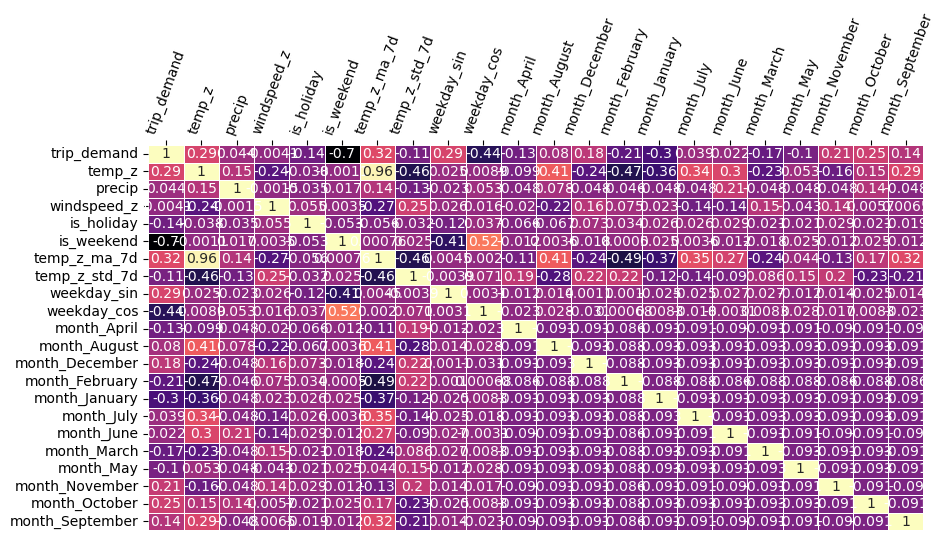

In [109]:
# Calculating the correlation matrix for census tract '17031081401.0'
correlation_matrix = taxi_by_census_tract_24H.loc[17031081401.0].corr()
correlation_features = correlation_matrix.index

f, axes = plt.subplots(figsize=(10, 5))

# Plotting the correlation heatmap
sns.heatmap(taxi_by_census_tract_24H.loc[17031081401.0][correlation_features].corr(), annot=True, cmap = "magma", ax = axes , cbar=False, linewidth = 0.4)
axes.xaxis.tick_top()
axes.set_xticklabels(axes.get_xticklabels(),rotation=70)

plt.show()

**Correlation matrix for hexagon resolution 6 and daily time-bucket size**

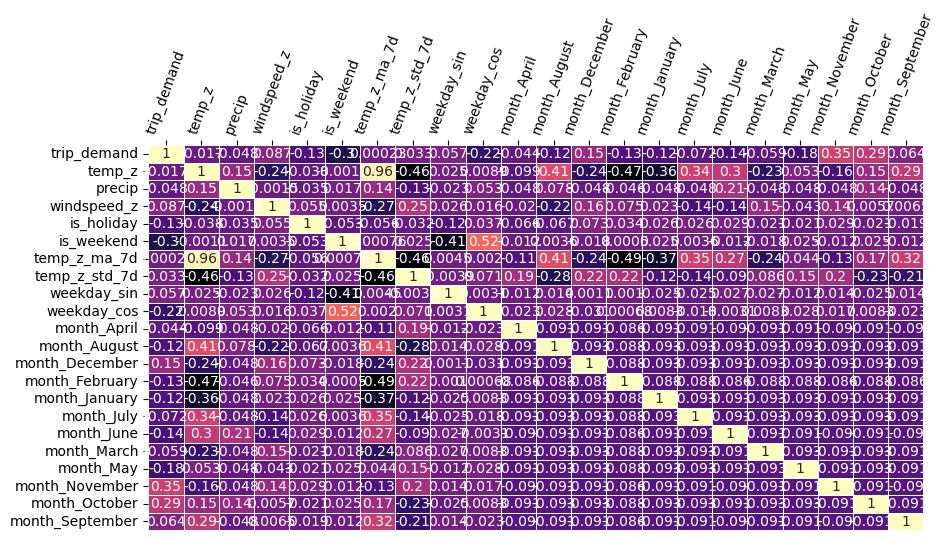

In [110]:
# Calculating the correlation matrix for Hexagon ID: '862664197ffffff'
correlation_matrix = taxi_by_h3_6_24H.loc["862664197ffffff"].corr()
correlation_features = correlation_matrix.index

f, axes = plt.subplots(figsize=(10, 5))

# Plotting the correlation heatmap
sns.heatmap(taxi_by_h3_6_24H.loc["862664197ffffff"][correlation_features].corr(), annot=True, cmap = "magma", ax = axes , cbar=False, linewidth = 0.4)
axes.xaxis.tick_top()
axes.set_xticklabels(axes.get_xticklabels(),rotation=70)

plt.show()

**Correlation matrix for hexagon resolution 7 and daily time-bucket size**

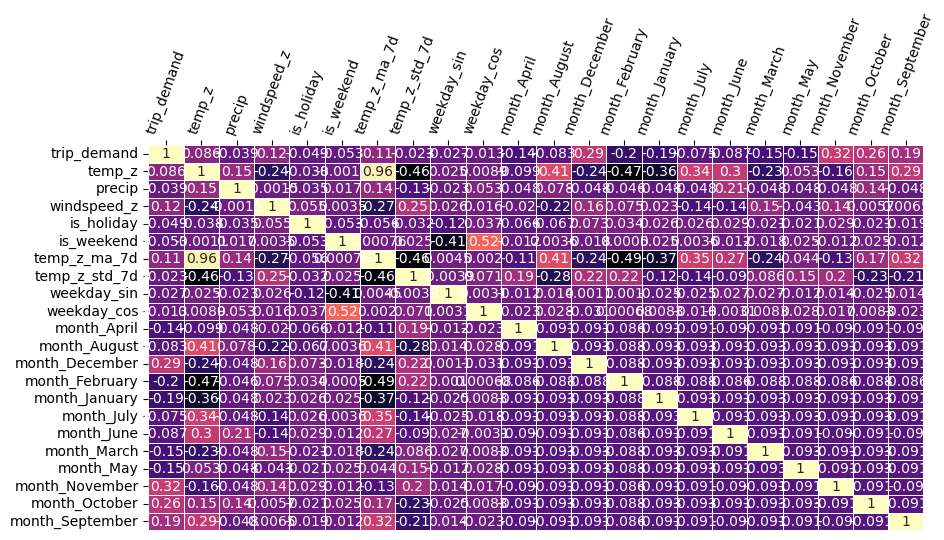

In [111]:
# Calculating the correlation matrix for Hexagon ID: '872664191ffffff'
correlation_matrix = taxi_by_h3_7_24H.loc["872664191ffffff"].corr()
correlation_features = correlation_matrix.index

f, axes = plt.subplots(figsize=(10, 5))

# Plotting the correlation heatmap
sns.heatmap(taxi_by_h3_7_24H.loc["872664191ffffff"][correlation_features].corr(), annot=True, cmap = "magma", ax = axes , cbar=False, linewidth = 0.4)
axes.xaxis.tick_top()
axes.set_xticklabels(axes.get_xticklabels(),rotation=70)

plt.show()

#### Lasso Regression

Identifying which features are most important for the model's performance, and maybe eliminate the noise or redundant features that might be present in the data.
Using techniques like PCA (Principal Component Analysis) or Lasso regression can help to reduce the number of features without losing much information.

In [114]:
feature_columns

Index(['temp_z', 'precip', 'windspeed_z', 'is_holiday', 'is_weekend',
       'temp_z_ma_7d', 'temp_z_std_7d', 'weekday_sin', 'weekday_cos',
       'month_April', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September'],
      dtype='object')

In [113]:
# create a Lasso object with a specified alpha value
model_L1 = Lasso(alpha=0.01, max_iter=20000)

# select feature columns (excluding the target variable)
feature_columns = taxi_by_census_tract_24H.loc[17031081401.0].columns.drop('trip_demand')
X = taxi_by_census_tract_24H.loc[17031081401.0].iloc[:,1:]
y = taxi_by_census_tract_24H.loc[17031081401.0].iloc[:,0]

# fit the Lasso model to the data
model_L1.fit(X, y)

# get the feature importances (coefficients)
coefficients = model_L1.coef_

# print the feature importances
for feature, importance in zip(feature_columns, coefficients):
    print(feature, importance)

temp_z -8.332341178032191
precip -3.1449784242561796
windspeed_z 2.044862274782467
is_holiday -94.96684179169701
is_weekend -166.5511111652763
temp_z_ma_7d 25.5879124460595
temp_z_std_7d 12.284136168250969
weekday_sin -2.1300214460266984
weekday_cos -13.055978885463672
month_April -50.75994726482583
month_August 8.533672081231943
month_December 76.80093622998795
month_February -52.35249399328861
month_January -81.1495773823563
month_July 0.0
month_June -4.087862582588944
month_March -56.01753478083668
month_May -32.565126957439745
month_November 86.22258188071979
month_October 89.32030696088002
month_September 31.646127919772052


**Selection:** It might be good to keep all the features as we only done Lasso for 1 id. This serves only as a first indication and is not a conclusion!

### Feature Extraction

**Now we are using PCA to analyze if dimensionality reduction can be benefitial for our feature set.**

Dummy variables represent categorical information in a way that maintains the distinction between categories. Combining them through PCA might lead to a loss of this distinction and result in less meaningful representations. Therefore we only do PCA on non dummy features.

We first start doing PCA on the census tract aggregation level with daily time buckets.

In [115]:
# select feature columns (excluding the target variable)
feature_columns = ['temp_z', 'windspeed_z','temp_z_ma_7d', 'temp_z_std_7d', 'weekday_sin', 'weekday_cos']
X_1 = taxi_by_census_tract_24H[feature_columns]

# calculate up to 6 PCA components
for i in range(1,6):
    pca = PCA(n_components = i)
    X_1_pca = pca.fit_transform(X_1)
    print("Components: ",pca.n_components_)
    print(pca.explained_variance_ratio_)
    print("Explained variance ratio: ",sum(pca.explained_variance_ratio_))
    
# choosing 3 principal components
pca = PCA(n_components = 3)
X_1_pca = pca.fit_transform(X_1)

Components:  1
[0.51703722]
Explained variance ratio:  0.5170372173658795
Components:  2
[0.51703722 0.22357064]
Explained variance ratio:  0.7406078590491469
Components:  3
[0.51703722 0.22357064 0.13969959]
Explained variance ratio:  0.880307453634008
Components:  4
[0.51703722 0.22357064 0.13969959 0.1088585 ]
Explained variance ratio:  0.9891659521698168
Components:  5
[0.51703722 0.22357064 0.13969959 0.1088585  0.00887124]
Explained variance ratio:  0.998037191547348


In [116]:
pca.feature_names_in_

array(['temp_z', 'windspeed_z', 'temp_z_ma_7d', 'temp_z_std_7d',
       'weekday_sin', 'weekday_cos'], dtype=object)

**Conclusion: Theoretically we can keep 3 components, as we have approx. 86% of the explained variance. But because we only do PCA on 6 features it might be not as benefitial to replace the features with the principal components. Therefore we continue to use the 6 original features!**

## Final Datasets

**Summary of Multiindex Datasets:**

<ins>Spatio-Temporal Aggregations for Census Tracts:</ins>
+ taxi_by_census_tract_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_census_tract_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_census_tract_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_census_tract_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 6:</ins>
+ taxi_by_h3_6_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_h3_6_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_h3_6_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_h3_6_24H &nbsp;&nbsp;: Daily Aggregation

<ins>Spatio-Temporal Aggregations for Hexagons with Resolution 7:</ins>
+ taxi_by_h3_7_1H &nbsp;&nbsp;: Hourly Aggregation
+ taxi_by_h3_7_2H &nbsp;&nbsp;: 2 Hourly Aggregation
+ taxi_by_h3_7_6H &nbsp;&nbsp;: 6 Hourly Aggregation
+ taxi_by_h3_7_24H &nbsp;&nbsp;: Daily Aggregation

**Summary of Features**

<ins>Target Variable:</ins> 
+ trip_demand : number of starting trips for each time bucket of year 2021

<ins>Features:</ins>

+ precip : binary feature that indicates whether the current time-bucket has precipitation or not.
+ windspeed_z : normalized average windspeed
+ temp_z : normalized average temperature
+ temp_z_ma_7d : moving average of the normalized temperature over 7 days
+ temp_z_std_7d : moving standard deviation of the normalized temperature over 7 days
+ weekday_sin : sine tranformed weekday
+ weekday_cos : cosine transformed weekday
+ is_weekend : binary feature to indicate whether the current time-bucket falls on a weekend or not
+ is_holiday : binary feature to indicate whether the current time-bucket falls on a holiday or not
+ 12 month dummies : month_January to month_December

Better save the Multiindex Datasets as pkl to preserve the dataframe structure
-> Reading with pd.read_pickle('file_path.pkl')

In [117]:
file_path = "./data/datasets/"
taxi_by_h3_6_1H.to_pickle(f"{file_path}taxi_by_h3_6_1H.pkl")
taxi_by_h3_6_2H.to_pickle(f"{file_path}taxi_by_h3_6_2H.pkl")
taxi_by_h3_6_6H.to_pickle(f"{file_path}taxi_by_h3_6_6H.pkl")
taxi_by_h3_6_24H.to_pickle(f"{file_path}taxi_by_h3_6_24H.pkl")

taxi_by_h3_7_1H.to_pickle(f"{file_path}taxi_by_h3_7_1H.pkl")
taxi_by_h3_7_2H.to_pickle(f"{file_path}taxi_by_h3_7_2H.pkl")
taxi_by_h3_7_6H.to_pickle(f"{file_path}taxi_by_h3_7_6H.pkl")
taxi_by_h3_7_24H.to_pickle(f"{file_path}taxi_by_h3_7_24H.pkl")

taxi_by_census_tract_1H.to_pickle(f"{file_path}taxi_by_census_tract_1H.pkl")
taxi_by_census_tract_2H.to_pickle(f"{file_path}taxi_by_census_tract_2H.pkl")
taxi_by_census_tract_6H.to_pickle(f"{file_path}taxi_by_census_tract_6H.pkl")
taxi_by_census_tract_24H.to_pickle(f"{file_path}taxi_by_census_tract_24H.pkl")